<h1> Stage2 - multiple energies </h1>

How good is the code without standardization? The problem is that at the moment the Code is standardized on the current dataset... and the dataset will change over time.

In [1]:
import myfunctions as mf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import uproot
from tensorflow.keras.optimizers import Adam
import time

In [2]:
# load data
rootfile = uproot.open("./stage2_clusters.root")
event = rootfile["user202302;1"]
xMC = event["x_MC"].array(library="np") #[:40000]
yMC = event["y_MC"].array(library="np") #[:40000]
EMC = event["E_MC"].array(library="np") #[:40000]
x_truth = event["x_truth"].array(library="np") #[:40000]
y_truth = event["y_truth"].array(library="np") #[:40000]
E_truth = event["E_truth"].array(library="np") #[:40000]
x_fit = event["x_fit"].array(library="np") #[:40000]
y_fit = event["y_fit"].array(library="np") #[:40000]
E_fit = event["E_fit"].array(library="np") #[:40000]

In [3]:
clustersNxN, coord, ind_del = mf.form_cluster(xMC, yMC, EMC)

This took  157.84251070022583 s


In [4]:
print("Useable clusters: ", len(clustersNxN))
print("Deleted clusters: ", len(ind_del))

Useable clusters:  753956
Deleted clusters:  54


As 50 compared to 0.7 M is rather small, I'll still use 5x5 clusters.

In [5]:
clusters = clustersNxN.reshape((clustersNxN.shape[0], 25))
# cut data and from trainings and test data
xMC_train, xMC_veri, yMC_train, yMC_veri, EMC_train, EMC_veri, x_truth_train, x_truth_veri, y_truth_train, y_truth_veri, E_truth_train, E_truth_veri, x_fit_veri, y_fit_veri, E_fit_veri, clusters_t, clusters_v, coord_t, coord_v = mf.training_and_validation_data(xMC, yMC, EMC, x_truth, y_truth, E_truth, x_fit, y_fit, E_fit, ind_del, clusters, coord)
# prep data
training = mf.prep_trainingsdata(x_truth_train, y_truth_train, E_truth_train, coord_t)
veri_truth_data = mf.prep_trainingsdata(x_truth_veri, y_truth_veri, E_truth_veri, coord_v)
veri_fit_data = mf.prep_trainingsdata(x_fit_veri, y_fit_veri, E_fit_veri, coord_v)

In [6]:
# standardize input
#clusters_t = mf.standardscore(clusters_t)
#clusters_v = mf.standardscore(clusters_v)

<h2> The network </h2>

This will be the basic network for stage 2. Do not use Layer Normalization as this makes the NN loose the information of total energy!

In [7]:
model = keras.Sequential([layers.Input(shape=(25)),
                         layers.Dense(64, activation="relu"),
                         layers.Dense(128, activation="relu"),
                         layers.Dense(256, activation="relu"),
                         layers.Dense(128, activation="relu"),
                         layers.Dense(64, activation="relu"),
                         layers.Dense(32, activation="relu"),
                         layers.Dense(3, activation=None)])
model.summary()
model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.00001))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1664      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 9

Check if GPU is running...

In [8]:
try:
    tf.debugging.set_log_device_placement(True)
    print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
except:
   pass 

GPU name:  []
Num GPUs Available:  0


In [9]:
a = time.time()
fit_hist = model.fit(clusters_t, training, batch_size=64, epochs=200, validation_split=0.1)
b = time.time()

print("This took ", (b-a)/60, "min")

Epoch 1/200
8482/8482 [==============================] - 8s 850us/step - loss: 261.4465 - val_loss: 19.7997
Epoch 2/200
8482/8482 [==============================] - 7s 862us/step - loss: 15.7997 - val_loss: 11.7753
Epoch 3/200
8482/8482 [==============================] - 7s 836us/step - loss: 11.1164 - val_loss: 10.1791
Epoch 4/200
8482/8482 [==============================] - 7s 838us/step - loss: 10.4075 - val_loss: 9.7813
Epoch 5/200
8482/8482 [==============================] - 7s 840us/step - loss: 10.1458 - val_loss: 9.6010
Epoch 6/200
8482/8482 [==============================] - 7s 837us/step - loss: 9.9936 - val_loss: 9.4960
Epoch 7/200
8482/8482 [==============================] - 7s 834us/step - loss: 9.8930 - val_loss: 9.4186
Epoch 8/200
8482/8482 [==============================] - 7s 836us/step - loss: 9.8279 - val_loss: 9.3819
Epoch 9/200
8482/8482 [==============================] - 7s 836us/step - loss: 9.7777 - val_loss: 9.3097
Epoch 10/200
8482/8482 [======================

Epoch 155/200
8482/8482 [==============================] - 7s 866us/step - loss: 8.5094 - val_loss: 8.2660
Epoch 156/200
8482/8482 [==============================] - 7s 835us/step - loss: 8.5025 - val_loss: 8.3052
Epoch 157/200
8482/8482 [==============================] - 7s 835us/step - loss: 8.4972 - val_loss: 8.3123
Epoch 158/200
8482/8482 [==============================] - 7s 840us/step - loss: 8.4924 - val_loss: 8.4283
Epoch 159/200
8482/8482 [==============================] - 7s 838us/step - loss: 8.4884 - val_loss: 8.2551
Epoch 160/200
8482/8482 [==============================] - 7s 839us/step - loss: 8.4834 - val_loss: 8.3076
Epoch 161/200
8482/8482 [==============================] - 7s 837us/step - loss: 8.4752 - val_loss: 8.2532
Epoch 162/200
8482/8482 [==============================] - 7s 834us/step - loss: 8.4715 - val_loss: 8.2382
Epoch 163/200
8482/8482 [==============================] - 7s 835us/step - loss: 8.4691 - val_loss: 8.3173
Epoch 164/200
8482/8482 [============

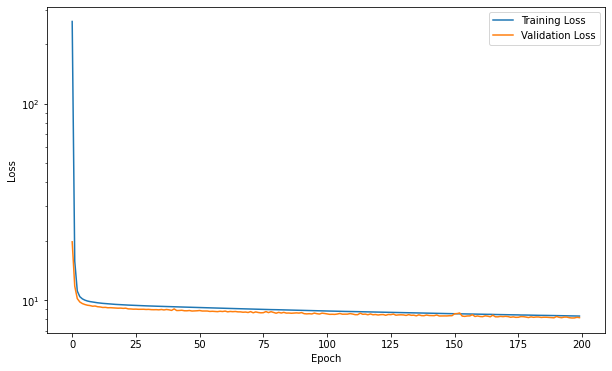

In [10]:
plt.rcParams["figure.figsize"] = (10,6)
mf.training_vs_validation_loss(fit_hist)

In [11]:
output = model.predict(clusters_v)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.

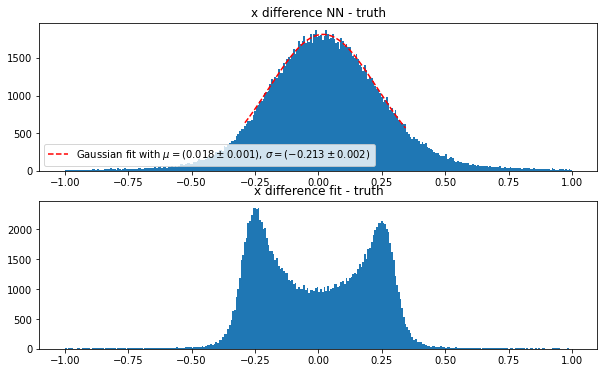

In [18]:
mf.histo_output(output.T[0], veri_fit_data.T[0], veri_truth_data.T[0], name="x", fit=True)

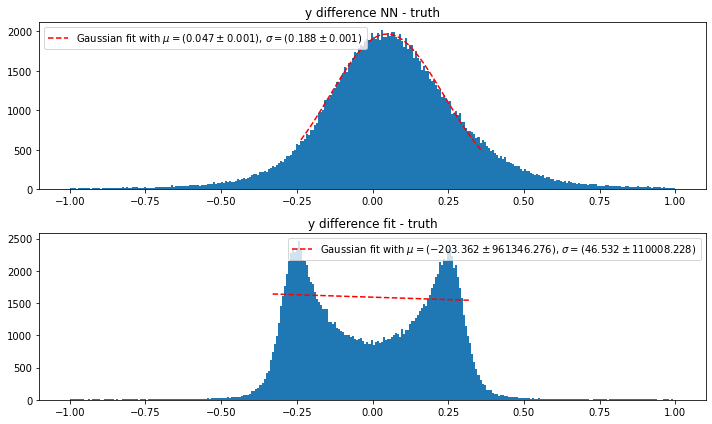

(array([4.74901299e-02, 1.87738786e-01, 9.25417914e+02]),
 array([1.08868133e-03, 1.44685868e-03, 5.72964344e+00]),
 array([-2.03362422e+02,  4.65324619e+01,  2.60668143e+09]),
 array([9.61346276e+05, 1.10008228e+05, 1.23371768e+14]))

In [13]:
mf.histo_output(output.T[1], veri_fit_data.T[1], veri_truth_data.T[1], name="y")

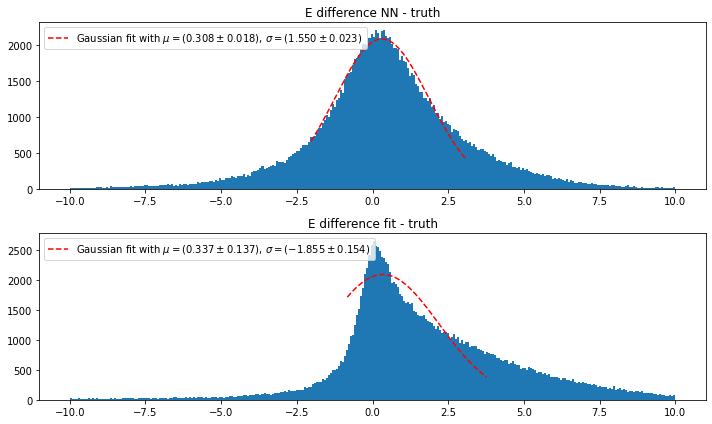

(array([3.08433829e-01, 1.55011619e+00, 8.11784738e+03]),
 array([1.82313018e-02, 2.32835183e-02, 9.89689230e+01]),
 array([ 3.36691567e-01, -1.85509098e+00,  9.70799030e+03]),
 array([1.37209754e-01, 1.54373648e-01, 7.36863988e+02]))

In [14]:
mf.histo_output(output.T[2], veri_fit_data.T[2], veri_truth_data.T[2], name="E", range_x=(-10,10), fit=True)

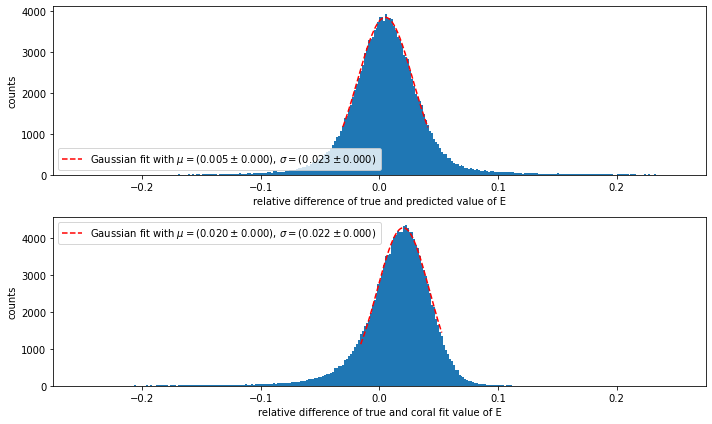

In [16]:
E_bad = mf.histo_output_rel(output.T[2], veri_fit_data.T[2], veri_truth_data.T[2], name="E", range_x=(-0.25,0.25), fit=True)

In [17]:
keras.models.save_model(model, 'stage2model_no_standardization')

INFO:tensorflow:Assets written to: stage2model_no_standardization/assets


<h2> summary </h2>

| (x/y/rel E) | $\mu$ | $\sigma$ |
| --- | --- | --- |
| no standardization |0.018 / 0.047 / 0.005 | 0.231 / 0.188 / 0.022|
| standardization | 0.021 / 0.058 / 0.005 | 0.123 / 0.125 / 0.022 |

No significant difference. But learning a bit slower (stronger gradient over time)